In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

mean = np.array([0.5,0.5,0.5])
std = np.array([0.5,0.5,0.5])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [2]:
!wget 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
!unzip 'hymenoptera_data.zip' 

--2020-10-24 01:04:05--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.37, 99.86.38.96, 99.86.38.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  21.3MB/s    in 2.1s    

2020-10-24 01:04:07 (21.3 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train

In [3]:
data_dir = '/content/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


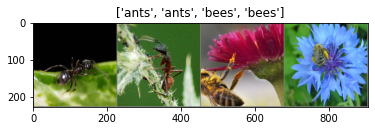

In [4]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
# Train over the ResNet18 network with new fully connected layers

model = models.resnet18(pretrained = True)

num_features = model.fc.in_features

model.fc = nn.Linear(num_features,2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),lr=0.001)

# Schedular
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# training 
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



512
Epoch 0/24
----------
train Loss: 0.7008 Acc: 0.5533
val Loss: 0.5491 Acc: 0.7516

Epoch 1/24
----------
train Loss: 0.5578 Acc: 0.7254
val Loss: 0.4066 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4863 Acc: 0.7746
val Loss: 0.3247 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4402 Acc: 0.8197
val Loss: 0.2795 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4225 Acc: 0.8115
val Loss: 0.2457 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4042 Acc: 0.8115
val Loss: 0.2280 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3882 Acc: 0.8115
val Loss: 0.2320 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3202 Acc: 0.8607
val Loss: 0.2210 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3532 Acc: 0.8279
val Loss: 0.2379 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3827 Acc: 0.7992
val Loss: 0.2036 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3744 Acc: 0.8279
val Loss: 0.2133 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3278 Acc: 0.8566
val Loss: 0.2145 Acc: 0.934

In [7]:
# Train only the final fully connected layers by freezing the other weights

model = models.resnet18(pretrained = True)

for param in model.parameters():
  param.requires_grad = False

num_features = model.fc.in_features

print(num_features)

model.fc = nn.Linear(num_features,2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),lr=0.001)

# Schedular
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# training 
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

512
Epoch 0/24
----------
train Loss: 0.7106 Acc: 0.5328
val Loss: 0.6066 Acc: 0.6536

Epoch 1/24
----------
train Loss: 0.6150 Acc: 0.6352
val Loss: 0.4938 Acc: 0.7712

Epoch 2/24
----------
train Loss: 0.5283 Acc: 0.7541
val Loss: 0.3935 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.5144 Acc: 0.7541
val Loss: 0.3600 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4743 Acc: 0.7664
val Loss: 0.3155 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4507 Acc: 0.8115
val Loss: 0.2989 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4679 Acc: 0.7664
val Loss: 0.2797 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.4596 Acc: 0.7828
val Loss: 0.2667 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4015 Acc: 0.8689
val Loss: 0.2725 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4101 Acc: 0.8361
val Loss: 0.2572 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4532 Acc: 0.8033
val Loss: 0.2678 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4330 Acc: 0.7951
val Loss: 0.2585 Acc: 0.9346